#Setup

In [1]:
from os.path import join
import os
import re

from google.colab import drive

import numpy as np

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2


device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/인지프/PLSU_4064_flip_rotate.zip" -d "/content/"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask2512.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask2512.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask255.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask255.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask533.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask533.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask2274.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask2274.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask3181.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask3181.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask1796.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask1796.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask1782.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask1782.j

# Sorting Data

In [2]:
## 파일 이름에서 숫자 부분을 추출하는 함수
def extract_number(file_name):
    numbers = re.findall(r'\d+', file_name)
    return int(numbers[0]) if numbers else 0


def list_files_in_directory(directory_path):
    items_in_directory = sorted(os.listdir(directory_path))
    files_in_directory = [item for item in items_in_directory if os.path.isfile(os.path.join(directory_path, item))]

    return files_in_directory

In [3]:
# 이미지와 마스크 파일 경로 가져오기 및 정렬
mask_directory = '/content/PLSU_4064_flip_rotate/Mask'
mask_files = list_files_in_directory(mask_directory)
sorted_mask_files = sorted(mask_files, key=extract_number)
print(sorted_mask_files)
print(len(sorted_mask_files))



image_directory = '/content/PLSU_4064_flip_rotate/img'
image_files = list_files_in_directory(image_directory)
sorted_image_files = sorted(image_files, key=extract_number)
print(sorted_image_files)
print(len(sorted_image_files))



# 이미지와 마스크 파일의 전체 경로 생성
image_paths = [os.path.join(image_directory, file_name) for file_name in sorted_image_files]
mask_paths = [os.path.join(mask_directory, file_name) for file_name in sorted_mask_files]



# 이미지와 마스크의 경로 예시를 보고 혹시 파일 리스트가 순서대로 정렬되어 있지 않는지 확인해봅니다.
print(f'이미지 경로 예시 : {image_paths[:5]}')
print(f'마스크 경로 예시 : {mask_paths[:5]}')

['mask1.jpg', 'mask2.jpg', 'mask3.jpg', 'mask4.jpg', 'mask5.jpg', 'mask6.jpg', 'mask7.jpg', 'mask8.jpg', 'mask9.jpg', 'mask10.jpg', 'mask11.jpg', 'mask12.jpg', 'mask13.jpg', 'mask14.jpg', 'mask15.jpg', 'mask16.jpg', 'mask17.jpg', 'mask18.jpg', 'mask19.jpg', 'mask20.jpg', 'mask21.jpg', 'mask22.jpg', 'mask23.jpg', 'mask24.jpg', 'mask25.jpg', 'mask26.jpg', 'mask27.jpg', 'mask28.jpg', 'mask29.jpg', 'mask30.jpg', 'mask31.jpg', 'mask32.jpg', 'mask33.jpg', 'mask34.jpg', 'mask35.jpg', 'mask36.jpg', 'mask37.jpg', 'mask38.jpg', 'mask39.jpg', 'mask40.jpg', 'mask41.jpg', 'mask42.jpg', 'mask43.jpg', 'mask44.jpg', 'mask45.jpg', 'mask46.jpg', 'mask47.jpg', 'mask48.jpg', 'mask49.jpg', 'mask50.jpg', 'mask51.jpg', 'mask52.jpg', 'mask53.jpg', 'mask54.jpg', 'mask55.jpg', 'mask56.jpg', 'mask57.jpg', 'mask58.jpg', 'mask59.jpg', 'mask60.jpg', 'mask61.jpg', 'mask62.jpg', 'mask63.jpg', 'mask64.jpg', 'mask65.jpg', 'mask66.jpg', 'mask67.jpg', 'mask68.jpg', 'mask69.jpg', 'mask70.jpg', 'mask71.jpg', 'mask72.jpg', 

# Custom Dataset

In [ ]:
#No augmentation, test시 이미지만 반환하도록 하는 코드
# class PalmDataset(Dataset):
#     def __init__(self, image_paths, mask_paths, size=(256, 256), mode='train'):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.resize = size
#         self.mode = mode

#         # 기본 변환: 모든 모드에 적용
#         base_transform = [
#             A.Resize(*size),
#             A.Normalize(),
#             ToTensorV2()
#         ]

#         # Train 모드에만 적용될 추가적인 데이터 증강 변환
#         if mode == 'train':
#             self.transform = A.Compose([
#                 # data augmentation 적는 곳
#             ] + base_transform)
#         else:
#             # Validation 및 Test 모드에서는 기본 변환만 적용
#             self.transform = A.Compose(base_transform)

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image = cv2.imread(self.image_paths[idx])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         if self.mode in ['train', 'val']:
#             mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
#             mask = mask / 255
#             augmented = self.transform(image=image, mask=mask)
#             return augmented['image'], augmented['mask']
#         else:
#             # 테스트 모드에서는 마스크 없이 이미지만 반환
#             return self.transform(image=image)['image']

In [4]:
from torch.utils.data import Dataset
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PalmDataset(Dataset):
    def __init__(self, image_paths, mask_paths, size=(256, 256), mode='train'):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.resize = size
        self.mode = mode

        # 기본 변환: 모든 모드에 적용
        base_transform = [
            A.Resize(*size),
            A.Normalize(),
            ToTensorV2()
        ]

        transform = [
            A.Resize(*size),
            ToTensorV2()
        ]
        self.normal_transform = A.Compose(transform)

        # Train 모드에만 적용될 추가적인 데이터 증강 변환
        if mode == 'train':
            self.transform = A.Compose([
                # data augmentation 적는 곳
            ] + base_transform)
        else:
            # Validation 및 Test 모드에서는 기본 변환만 적용
            self.transform = A.Compose(base_transform)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = mask / 255  # Normalize the mask to be [0, 1]

        # 변환 적용
        augmented = self.transform(image=image, mask=mask)
        augmented2 = self.normal_transform(image=image, mask=mask)
        return augmented['image'], augmented['mask'], augmented2['image']


# Data Lodaer

In [5]:
#train:val:test = 75%:15%:15%
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
test_image_paths, val_image_paths, test_mask_paths, val_mask_paths = train_test_split(test_image_paths, test_mask_paths, test_size=0.5, random_state=42)

train_dataset = PalmDataset(train_image_paths, train_mask_paths, size=(256,256),mode='train')
val_dataset = PalmDataset(val_image_paths, val_mask_paths, size=(256,256),mode='val')
test_dataset = PalmDataset(test_image_paths, test_mask_paths, size=(256,256),mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

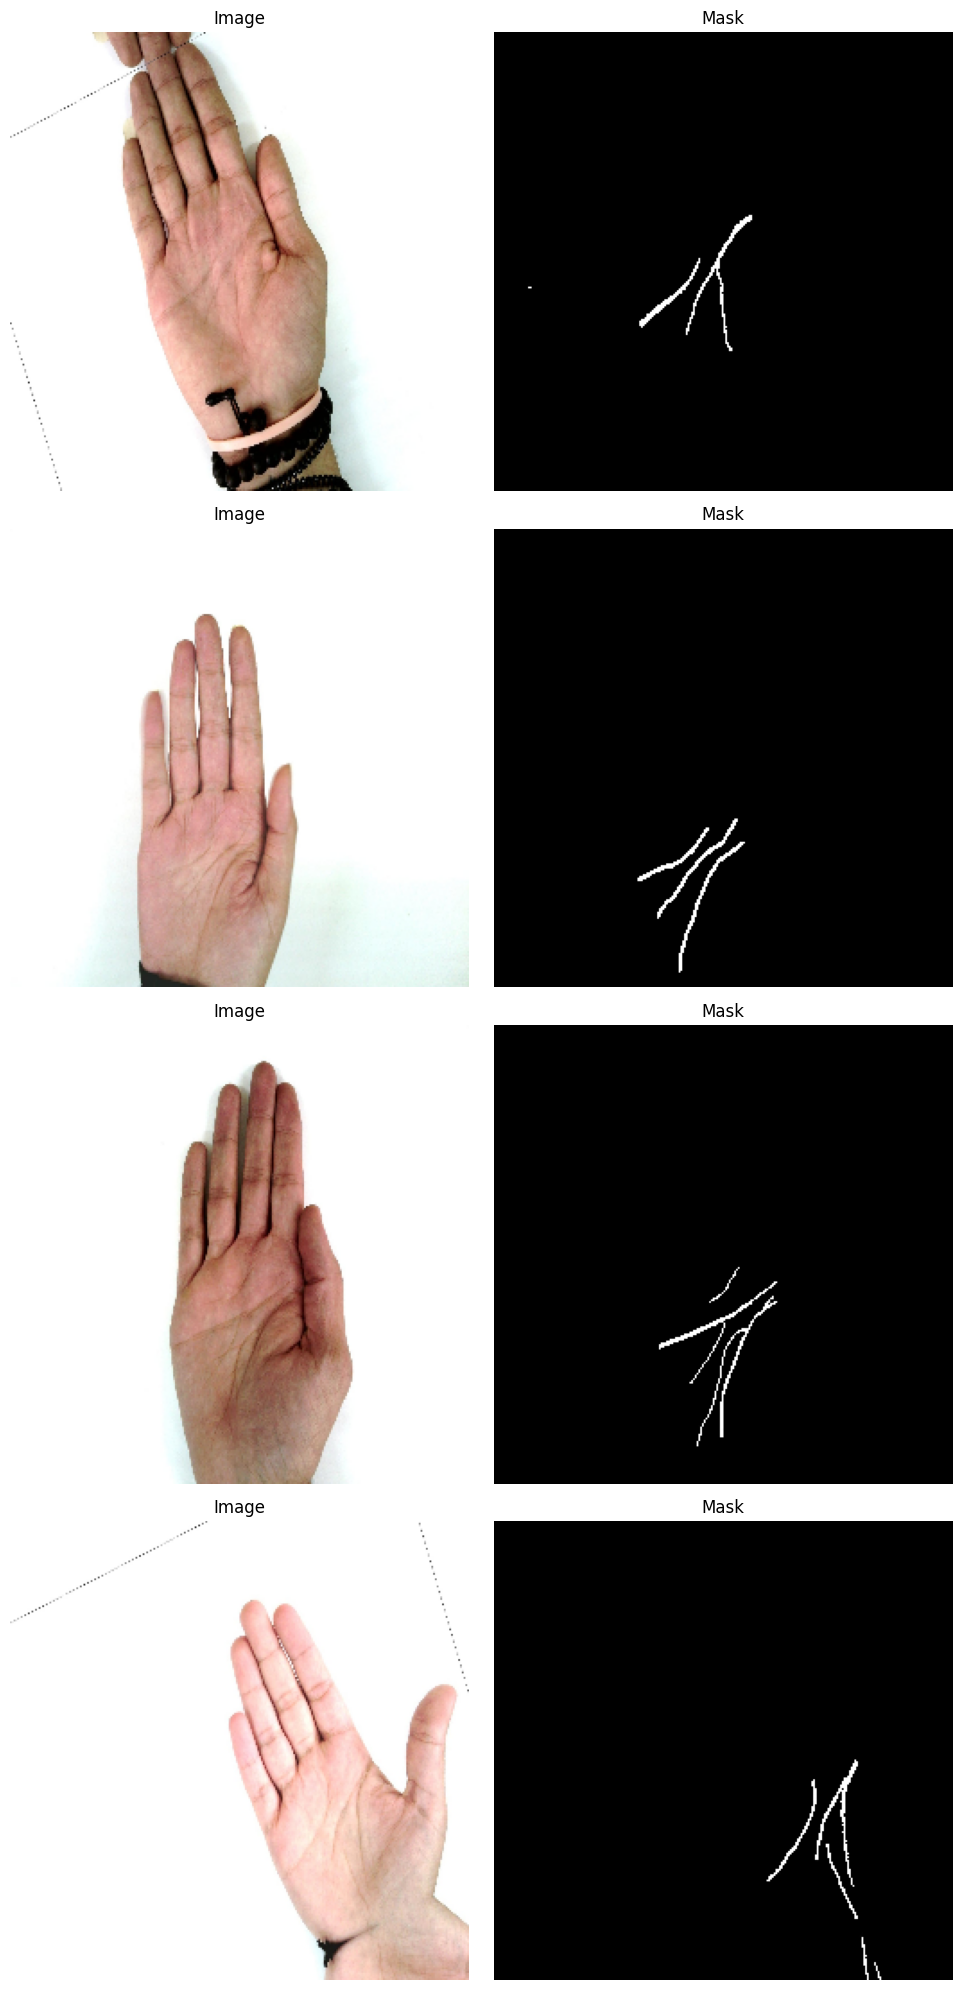

In [6]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 첫 번째 배치 가져오기
images, masks, images_ = next(iter(train_loader))

# 이미지와 마스크 시각화
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for i in range(4):
    ax[i, 0].imshow(images_[i].permute(1, 2, 0))  # 이미지
    ax[i, 1].imshow(masks[i], cmap='gray')  # 마스크
    ax[i, 0].set_title("Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Define Model

In [7]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)


    def forward(self, x):
        return self.conv(x)

In [8]:
class ContextFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.context_modeling = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.Softmax2d()
        )
        self.context_transform1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.context_transform2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1)
        )

    def forward(self, x):
        x1 = nn.MaxPool2d(2)(x)
        x2 = self.context_modeling(x1) * x1
        return self.context_transform1(x2) * x1 + self.context_transform2(x2)

In [9]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.cfm = ContextFusion(512)
        self.up1 = Up(1024, 512 // 2)
        self.up2 = Up(512, 256 // 2)
        self.up3 = Up(256, 128 // 2)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.cfm(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Scoring

In [10]:
# F-1 Score와 IoU 계산을 위한 함수
def calculate_f1_score(preds, labels):
    # 시그모이드 함수를 적용하여 확률로 변환
    preds = torch.sigmoid(preds)
    # 확률을 이진화 (0.5를 임계값으로 사용)
    preds = (preds > 0.5).float()

    # True Positives, False Positives, False Negatives 계산
    tp = (preds * labels).sum(dim=[1, 2, 3])
    fp = (preds * (1 - labels)).sum(dim=[1, 2, 3])
    fn = ((1 - preds) * labels).sum(dim=[1, 2, 3])

    # F1 Score 계산
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    # 배치 내 모든 이미지에 대한 F1 Score의 평균 반환
    return f1.mean().item()

def calculate_iou(preds, labels):
    # 시그모이드 함수를 적용하여 확률로 변환
    preds = torch.sigmoid(preds)
    # 확률을 이진화 (0.5를 임계값으로 사용)
    preds = (preds > 0.5).float()

    # True Positives, False Positives, False Negatives 계산
    intersection = (preds * labels).sum(dim=[1, 2, 3])  # 교집합
    total = (preds + labels).sum(dim=[1, 2, 3])  # 합집합
    union = total - intersection  # 합집합 - 교집합

    # IoU 계산
    iou = (intersection + 1e-6) / (union + 1e-6)  # 0으로 나누는 것을 방지하기 위한 작은 값 추가

    # 배치 내 모든 이미지에 대한 IoU의 평균 반환
    return iou.mean().item()


# Loss function

In [11]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs : 모델 출력, targets : 실제 마스크
        inputs = torch.sigmoid(inputs)  # 시그모이드 함수를 적용하여 확률로 변환

        # 평탄화
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Dice 계수 계산
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)

        # Dice 손실
        return 1 - dice

In [12]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

ERROR: Operation cancelled by user


ModuleNotFoundError: ignored

#Train

100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


Epoch 1, Loss: 0.21902951120995404, Validation Loss: 0.08576174788177013, Avg F-1: 0.0, mIoU: 2.4493425287985814e-09


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


Epoch 2, Loss: 0.05651252331693521, Validation Loss: 0.040268898382782935, Avg F-1: 0.28084487169981004, mIoU: 0.17508668825030327


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 3, Loss: 0.029791096350952482, Validation Loss: 0.02538869306445122, Avg F-1: 0.576679427921772, mIoU: 0.413492850959301


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 4, Loss: 0.020493357557426678, Validation Loss: 0.01910412944853306, Avg F-1: 0.5575422644615173, mIoU: 0.3986463099718094


100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Epoch 5, Loss: 0.016472387368257128, Validation Loss: 0.01572885848581791, Avg F-1: 0.6172428905963898, mIoU: 0.45468937903642653


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Epoch 6, Loss: 0.013829997311649697, Validation Loss: 0.013626413326710463, Avg F-1: 0.6743221193552017, mIoU: 0.5130109950900078


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 7, Loss: 0.012194494319179754, Validation Loss: 0.011292128544300794, Avg F-1: 0.677435240149498, mIoU: 0.516513979434967


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 8, Loss: 0.011154154064447691, Validation Loss: 0.01089264489710331, Avg F-1: 0.6895369201898575, mIoU: 0.5299467846751214


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 9, Loss: 0.010468389106433043, Validation Loss: 0.010989615228027105, Avg F-1: 0.6954232722520828, mIoU: 0.536496713757515


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Epoch 10, Loss: 0.009950205599993801, Validation Loss: 0.010021636774763466, Avg F-1: 0.696691632270813, mIoU: 0.5385056048631668


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Epoch 11, Loss: 0.009431468908873837, Validation Loss: 0.0094618855509907, Avg F-1: 0.715292575955391, mIoU: 0.5597565591335296


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Epoch 12, Loss: 0.009287667356096627, Validation Loss: 0.009501603292301297, Avg F-1: 0.719876566529274, mIoU: 0.565202122926712


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 13, Loss: 0.009214098743173513, Validation Loss: 0.009357355954125523, Avg F-1: 0.7177592724561691, mIoU: 0.5627587318420411


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Epoch 14, Loss: 0.009153074124472195, Validation Loss: 0.009295359300449491, Avg F-1: 0.7214428782463074, mIoU: 0.5671417653560639


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Epoch 15, Loss: 0.009086712326310325, Validation Loss: 0.00935022346675396, Avg F-1: 0.7232783049345016, mIoU: 0.5693802535533905


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 16, Loss: 0.009030448963467995, Validation Loss: 0.0092744670342654, Avg F-1: 0.7234968841075897, mIoU: 0.569645670056343


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 17, Loss: 0.008957814686837491, Validation Loss: 0.009151389775797724, Avg F-1: 0.7232146620750427, mIoU: 0.5693834483623504


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 18, Loss: 0.008907997844677962, Validation Loss: 0.00911458618938923, Avg F-1: 0.7193837940692902, mIoU: 0.5648437350988388


100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Epoch 19, Loss: 0.00884471715459328, Validation Loss: 0.009099926799535751, Avg F-1: 0.722791975736618, mIoU: 0.5689357250928879


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 20, Loss: 0.008741150045076782, Validation Loss: 0.009027064032852649, Avg F-1: 0.7243725776672363, mIoU: 0.5707515895366668


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 21, Loss: 0.008718767376051526, Validation Loss: 0.009027719916775822, Avg F-1: 0.7240554720163346, mIoU: 0.5703745990991592


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Epoch 22, Loss: 0.008704835554229075, Validation Loss: 0.009015303431078791, Avg F-1: 0.7249444335699081, mIoU: 0.5714787095785141


100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


Epoch 23, Loss: 0.008694982344514868, Validation Loss: 0.008997142780572176, Avg F-1: 0.7283454716205597, mIoU: 0.575608742237091


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 24, Loss: 0.008688807089844446, Validation Loss: 0.009013053914532065, Avg F-1: 0.7260452449321747, mIoU: 0.5728269517421722


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Epoch 25, Loss: 0.008675791098202547, Validation Loss: 0.008993494510650634, Avg F-1: 0.7287190049886704, mIoU: 0.5760416120290757


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Epoch 26, Loss: 0.00866055806177888, Validation Loss: 0.009011781448498369, Avg F-1: 0.7255657404661179, mIoU: 0.5722586691379548


100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Epoch 27, Loss: 0.008651228161172921, Validation Loss: 0.008996765594929457, Avg F-1: 0.7258005440235138, mIoU: 0.5725424379110337


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 28, Loss: 0.008642435654621111, Validation Loss: 0.008979869587346912, Avg F-1: 0.7282230108976364, mIoU: 0.5754406958818435


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 29, Loss: 0.008626199050105355, Validation Loss: 0.008974178601056338, Avg F-1: 0.7272459506988526, mIoU: 0.5742949187755585


100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


Epoch 30, Loss: 0.008621608639617315, Validation Loss: 0.008971704635769129, Avg F-1: 0.7279632568359375, mIoU: 0.5751690715551376


100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 31, Loss: 0.008618501962026518, Validation Loss: 0.008973181713372469, Avg F-1: 0.7267342746257782, mIoU: 0.5736821353435516


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 32, Loss: 0.008619866857116812, Validation Loss: 0.008974779769778252, Avg F-1: 0.7269109606742858, mIoU: 0.5739088803529739


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Epoch 33, Loss: 0.008616901646378669, Validation Loss: 0.008973738085478545, Avg F-1: 0.7273040294647217, mIoU: 0.5743851035833358


100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


Epoch 34, Loss: 0.00861440481764547, Validation Loss: 0.008970555430278183, Avg F-1: 0.727912786602974, mIoU: 0.5751173913478851


100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Epoch 35, Loss: 0.008613822416643078, Validation Loss: 0.008970782207325102, Avg F-1: 0.7270612776279449, mIoU: 0.574065762758255
Early stopping triggered


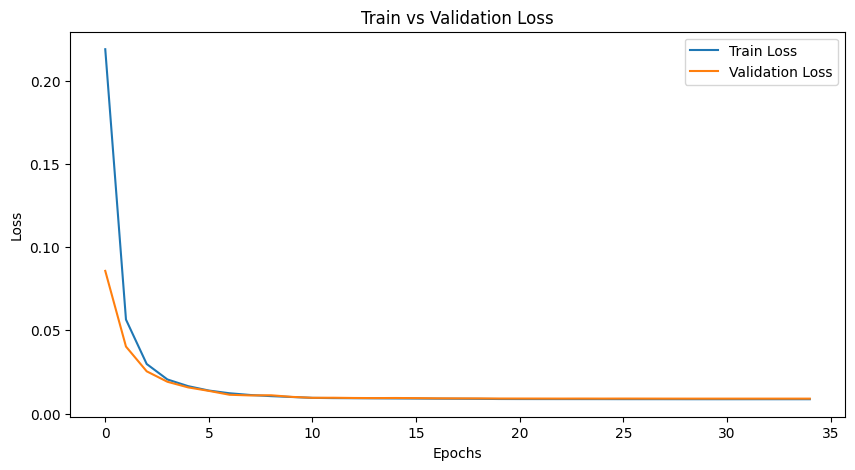

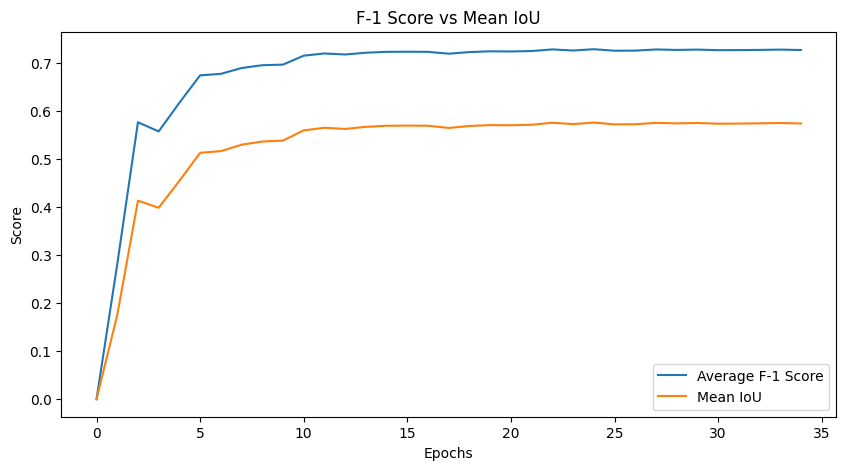

In [12]:
import matplotlib.pyplot as plt

# 성능 기록을 위한 리스트 초기화
train_losses = []
val_losses = []
f1_scores_epochs = []
iou_scores_epochs = []



#하이퍼 파라미터
num_epochs = 50
learning_rate = 0.001
T_max = 50  # 학습률 주기

# 최상의 모델을 저장하기 위한 초기 설정
best_iou_score = 0.0
early_stopping_counter = 0
patience = 10  # 성능이 개선되지 않는 에포크 한계값

# model 초기화
model = UNet(n_channels=3, n_classes=1).to(device)
model = model.to(device)

#loss function과 optimizer 정리
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=False)

# CosineAnnealingLR 스케줄러 초기화
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=8)

# training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks, _ in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #Learning Rate 조정
    scheduler.step(epoch_loss)

    train_losses.append(epoch_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0
    iou_scores = []
    f1_scores = []
    with torch.no_grad():
        for images, masks, _ in tqdm(val_loader):  # val_loader는 검증 데이터셋에 대한 DataLoader입니다.
            images = images.float().to(device)
            masks = masks.float().to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # F-1 Score와 IoU 계산
            f1 = calculate_f1_score(outputs, masks)
            iou = calculate_iou(outputs, masks)
            f1_scores.append(f1)
            iou_scores.append(iou)

    # 평균 IoU 및 손실 계산
    val_loss /= len(val_loader)
    avg_f1 = np.mean(f1_scores)
    avg_iou = np.mean(iou_scores)
    val_losses.append(val_loss)
    f1_scores_epochs.append(avg_f1)
    iou_scores_epochs.append(avg_iou)


    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}, Validation Loss: {val_loss}, Avg F-1: {avg_f1}, mIoU: {avg_iou}')

    # Early Stopping
    if avg_iou > best_iou_score:
        best_iou_score = avg_iou
        early_stopping_counter = 0
        # 가장 좋은 모델 저장
        torch.save(model.state_dict(), '/content/drive/MyDrive/인지프/checkpoints/snu_best_model_original.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

# 학습 및 검증 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

# F-1 Score와 mIoU Score 그래프
plt.figure(figsize=(10, 5))
plt.plot(f1_scores_epochs, label='Average F-1 Score')
plt.plot(iou_scores_epochs, label='Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('F-1 Score vs Mean IoU')
plt.legend()
plt.show()

#Test

In [13]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from PIL import Image

In [14]:
model = UNet(n_channels=3, n_classes=1).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/인지프/checkpoints/snu_best_model_original.pth'))

<All keys matched successfully>

In [15]:
#evaluate Test
# 모델을 평가 모드로 설정
model.eval()

# 점수 초기화
total_f1_score = 0.0
total_iou_score = 0.0
num_samples = 0

# 테스트 데이터셋에 대한 루프
for images, masks, _ in test_loader:
    with torch.no_grad():
        # 데이터를 장치에 로드
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)

        # 모델 예측
        outputs = model(images)

        # F1 점수와 IoU 점수 계산
        f1 = calculate_f1_score(outputs, masks)
        iou = calculate_iou(outputs, masks)
        total_f1_score += f1
        total_iou_score += iou
        num_samples += 1

# 평균 F1 점수와 IoU 점수 출력
avg_f1_score = total_f1_score / num_samples
avg_iou_score = total_iou_score / num_samples
print(f"Average F1 Score on Test Set: {avg_f1_score}")
print(f"Average IoU Score on Test Set: {avg_iou_score}")

Average F1 Score on Test Set: 0.7286713659763336
Average IoU Score on Test Set: 0.5756729125976563


#Test 1 | f1: 0.7194544076919556, iou: 0.5643227100372314


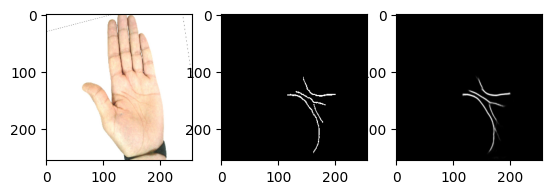

#Test 2 | f1: 0.7241451740264893, iou: 0.5701695084571838


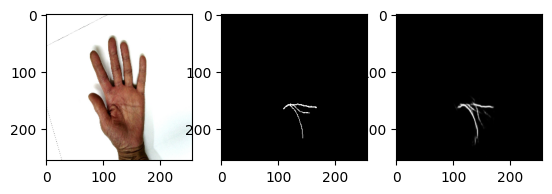

#Test 3 | f1: 0.7404450178146362, iou: 0.5902910232543945


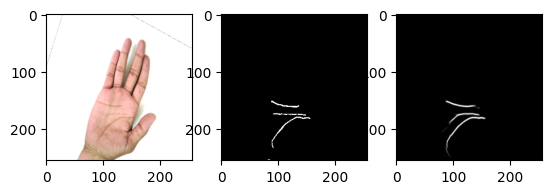

#Test 4 | f1: 0.7169002294540405, iou: 0.5625985860824585


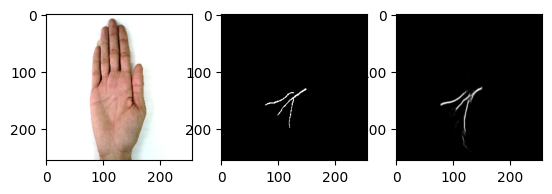

#Test 5 | f1: 0.7434878349304199, iou: 0.593535304069519


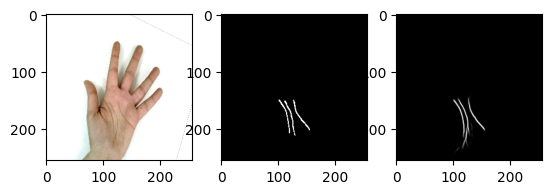

#Test 6 | f1: 0.7253177165985107, iou: 0.5706112384796143


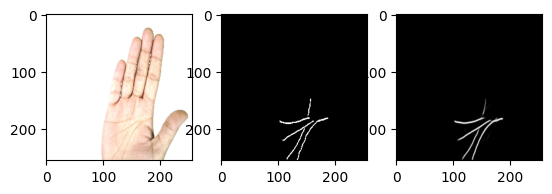

#Test 7 | f1: 0.7251928448677063, iou: 0.5722986459732056


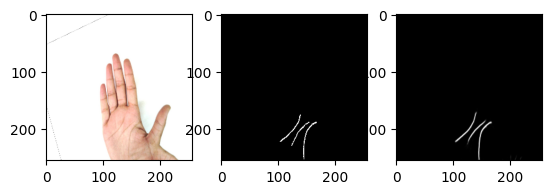

#Test 8 | f1: 0.7330821752548218, iou: 0.5809968113899231


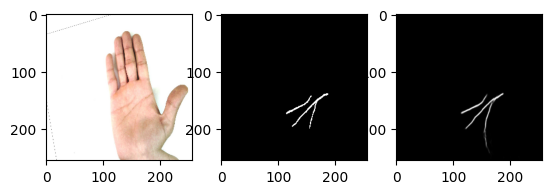

#Test 9 | f1: 0.725886344909668, iou: 0.5721283555030823


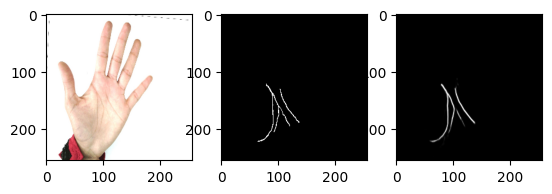

#Test 10 | f1: 0.7318515777587891, iou: 0.5801531672477722


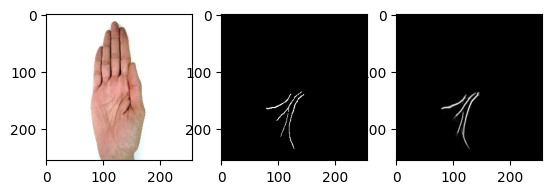

In [16]:
#Print Test Mask
model.eval()

k = 1
f1_scores = []
iou_scores = []
for images, masks, real in test_loader:
    if k > 10:
        break
    with torch.no_grad():
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)
        outputs = model(images)

        # F1와 IoU 계산
        f1 = calculate_f1_score(outputs, masks)
        iou = calculate_iou(outputs, masks)
        f1_scores.append(f1)
        iou_scores.append(iou)

        print(f"#Test {k} | f1: {f1}, iou: {iou}")

        # 시각화
        img_cpu = real[0].cpu().numpy().transpose(1, 2, 0)  # 첫 번째 이미지 선택
        mask_cpu = masks[0].squeeze().cpu().numpy()           # 첫 번째 마스크 선택
        output_sigmoid = torch.sigmoid(outputs[0]).squeeze().cpu().numpy()  # 첫 번째 출력 선택, 채널 차원 제거
        plt.subplot(1, 3, 1)
        plt.imshow(img_cpu)
        plt.subplot(1, 3, 2)
        plt.imshow(mask_cpu, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.imshow(output_sigmoid, cmap='gray')
        plt.show()
        k += 1

#Experiments

In [ ]:
pip install pyheif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 12.4 MB/s eta 0:00:00


In [ ]:
import pyheif

In [ ]:
def heic_to_jpeg(heic_dir, jpeg_dir):

    heif_file = pyheif.read(heic_dir)

    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride
        )

    print(heif_file)
    image.save(jpeg_dir,"JPEG")

In [ ]:
heic_to_jpeg("/content/IMG_5076.heic", "/content/IMG_5076.jpeg")

<HeifFile 2806x3787 RGB with 31931984 bytes data>


In [ ]:
# 단일 이미지에 대한 전처리 및 데이터 증강을 수행하는 함수
def preprocess_image(img_path, size=(256, 256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 데이터 증강 및 전처리 파이프라인
    transform = A.Compose([
        A.Resize(*size),
        A.Normalize(),
        ToTensorV2()
    ])

    # 변환 적용
    transformed = transform(image=image)
    return transformed['image']

In [ ]:
# 단일 이미지를 검출하는 함수
def detect(jpeg_dir, model, device, save=True):
    # 이미지 전처리
    image = preprocess_image(jpeg_dir)

    # 모델 예측
    with torch.no_grad():
        image = image.float().unsqueeze(0).to(device)
        outputs = model(image)

    # 시각화
    pil_img = Image.open(jpeg_dir).convert('RGB').resize((256, 256), resample=Image.NEAREST)
    img_cpu = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    output_sigmoid = torch.sigmoid(outputs).squeeze(0).cpu().numpy().squeeze()  # 첫 번째 차원 제거

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(pil_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(output_sigmoid, cmap='gray')  # 2차원 배열
    plt.title('Predicted Mask')
    plt.show()

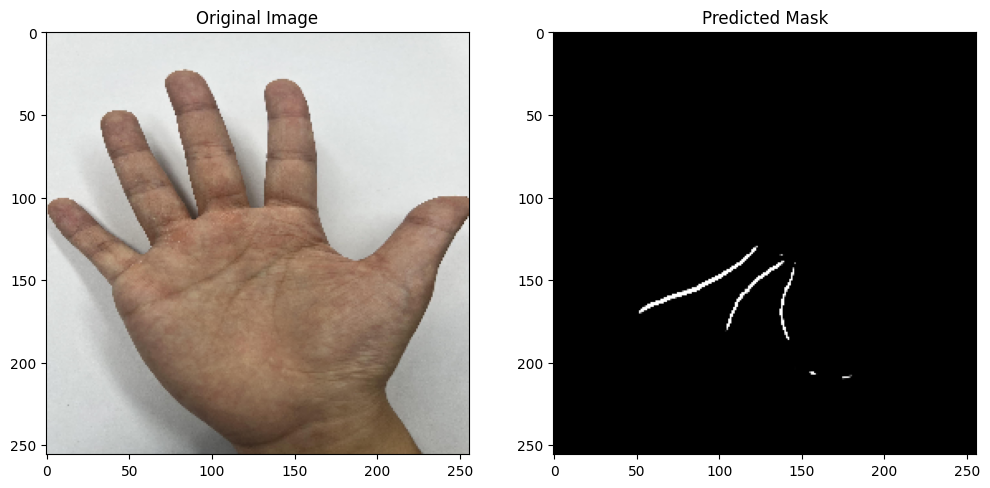

In [ ]:
detect("/content/IMG_5076.jpeg",model,device)

In [ ]:
detect("./inputs/hand2_1.jpeg")
detect("./inputs/hand2_2.jpeg")
detect("./inputs/hand2_3.jpg")
detect("./inputs/hand2_4.jpg")

In [ ]:
detect("./inputs/hand4_1.jpeg")
detect("./inputs/hand4_2.jpeg")
detect("./inputs/hand4_3.jpg")
detect("./inputs/hand4_4.jpg")